In [32]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [33]:
# Here process the tabular data to be graph
import pandas as pd
import numpy as np
import io
from google.colab import files

In [34]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['heart.csv']))
df['ID'] = np.arange(len(df))
# df.head()

Saving heart.csv to heart (1).csv


In [35]:
# Sort to define the order of nodes
sorted_df = df.sort_values(by="ID")
# sorted_df.head()

In [36]:
# Select node features
node_features = sorted_df[["age", "sex", "trtbps", "chol", "thalachh", "oldpeak", "fbs", "restecg", "exng", "slp", "caa", "thall"]]
# node_features.head()

In [37]:
# Get one hot encoding of columns fbs
one_hot_fbs = pd.get_dummies(node_features['fbs']) 
one_hot_fbs = one_hot_fbs.rename({0: 'No_fbs', 1: 'Yes_fbs'}, axis='columns')
# one_hot_fbs.head()

In [38]:
# Get one hot encoding of columns restecg
one_hot_restecg = pd.get_dummies(node_features['restecg']) 
one_hot_restecg = one_hot_restecg.rename({0: 'normal', 1: 'abnormal_1', 2:'abnormal_2'}, axis='columns')
# one_hot_restecg.head()

In [39]:
# Get one hot encoding of columns exng
one_hot_exng = pd.get_dummies(node_features['exng']) 
one_hot_exng = one_hot_exng.rename({0: 'No_angina', 1: 'Yes_angina'}, axis='columns')
# one_hot_exng.head()

In [40]:
# Get one hot encoding of columns slp	
one_hot_slp	 = pd.get_dummies(node_features['slp']) 
one_hot_slp = one_hot_slp.rename({0: 'ST_unsloping', 1: 'ST_flat', 2:'ST_downsloping'}, axis='columns')
# one_hot_slp.head()

In [41]:
# Get one hot encoding of columns caa	
one_hot_caa	 = pd.get_dummies(node_features['caa']) 
one_hot_caa = one_hot_caa.rename({0: 'caa_1', 1: 'caa_2', 2:'caa_3', 3:'caa_4', 4:'caa_5'}, axis='columns')
# one_hot_caa.head()

In [42]:
# Get one hot encoding of columns thall
one_hot_thall	 = pd.get_dummies(node_features['thall']) 
one_hot_thall = one_hot_thall.rename({0: 'thall_null', 1: 'thall_fixed_defect', 2:'thall_normal', 3:'thall_reversable defect'}, axis='columns')
# one_hot_thall.head()

In [43]:
encoded_df = pd.concat([node_features, one_hot_fbs, one_hot_restecg, one_hot_exng, one_hot_slp, one_hot_caa, one_hot_thall], axis=1)
encoded_df = encoded_df.drop(['thalachh','fbs','restecg','exng','slp','caa','thall'], axis=1)
# encoded_df.head()

In [44]:
# Convert to numpy: the node feature matrix
encoded_df_np = encoded_df.to_numpy()
# encoded_df_np.shape 

In [45]:
#labels
# Select node features
labels = sorted_df[["output"]]  
# labels.head()

In [46]:
# Convert to numpy
labels_np = labels.to_numpy()
# labels_np.shape # [num_nodes, 1] --> node regression

In [47]:
# Remap patient IDs
df["ID"] = df.reset_index().index
# df["ID"].value_counts()

In [48]:
### Make edge index for the graph
import itertools

categories = df["fbs"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))

for category in categories:
    category_df = df[df["fbs"] == category]
    Patients = category_df["ID"].values
    # Build all combinations, as all players are connected
    permutations = list(itertools.combinations(Patients, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    category_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, category_edges])

# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

array([[  0,   0,   0, ..., 299, 299, 301],
       [  8,  14,  23, ..., 301, 302, 302]])

In [49]:
edge_index = torch.tensor(edge_index, dtype=torch.int64)

In [50]:
tensor_x = torch.tensor(encoded_df_np).to(torch.float32)   

In [51]:
tensor_y = torch.tensor(labels_np).to(torch.float32)   
# tensor_y = torch.from_numpy(labels_np).long()

In [52]:
from torch_geometric.data import Data
data = Data(x=tensor_x, edge_index=edge_index, y=tensor_y)

In [53]:
data.y.size()

torch.Size([303, 1])

In [54]:
# # #flatten the labels
# # data.y = data.y.flatten()
# data.y = data.y.squeeze()

We have a graph data object now. 

However we still need to mask it. Maks is binary vecotr in which each element corresponds to an node in graph.

If the element is 1 then it's not masked, vice versa. 

In [55]:
from torch_geometric.transforms import RandomNodeSplit as masking
msk = masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.4)
data = msk(data)

In [56]:
print(data)
print()
print("training samples",torch.sum(data .train_mask).item())
print("validation samples",torch.sum(data .val_mask ).item())
print("test samples",torch.sum(data .test_mask ).item())

Data(x=[303, 24], edge_index=[2, 34143], y=[303, 1], train_mask=[303], val_mask=[303], test_mask=[303])

training samples 121
validation samples 61
test samples 121


In [57]:
data.y[data.train_mask].size()

torch.Size([121, 1])

From here we do a visual of the graph

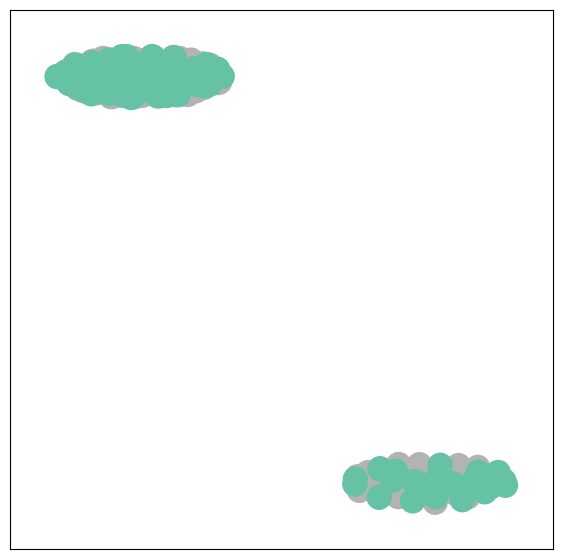

In [58]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected = True)
visualize_graph(G, color=data.y)

Then we try to mask the train data, test data to enalbe the training.

The next block will define the GCN model


In [59]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 1)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(24, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=1, bias=True)
)


**three graph convolution layers**


### Embedding the Graph Neural Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [303, 2]


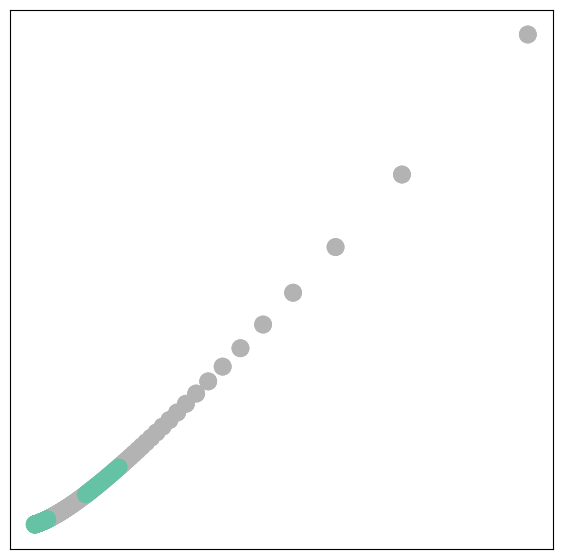

In [60]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the GNN

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

<IPython.core.display.Javascript object>

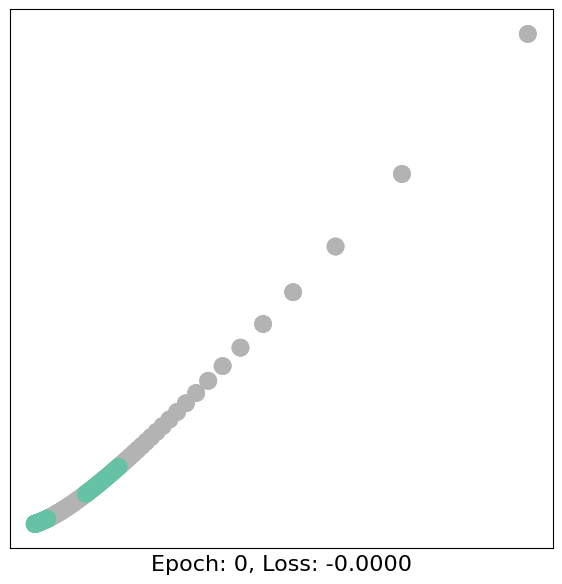

tensor(-0., grad_fn=<DivBackward1>)


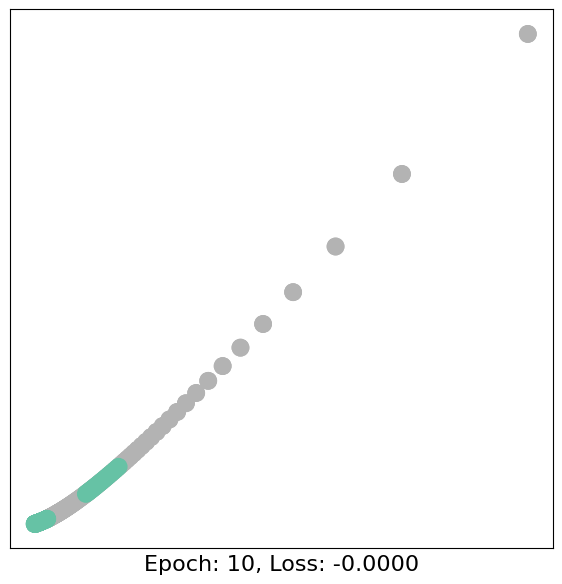

tensor(-0., grad_fn=<DivBackward1>)


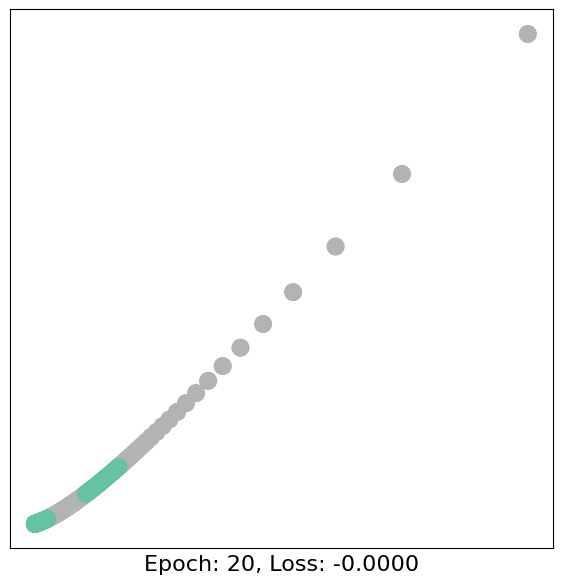

tensor(-0., grad_fn=<DivBackward1>)


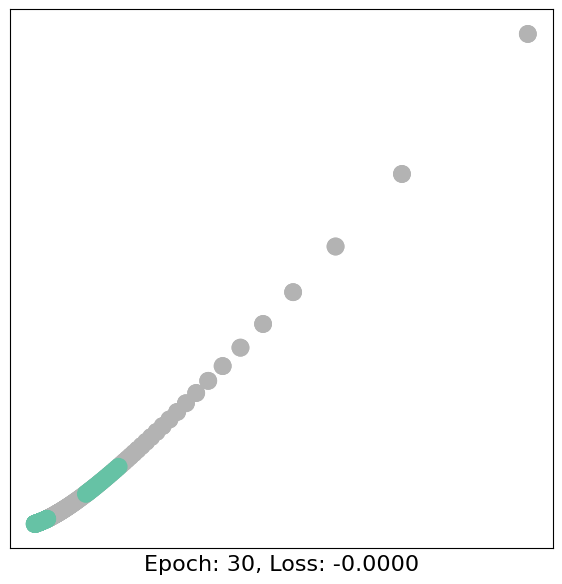

tensor(-0., grad_fn=<DivBackward1>)


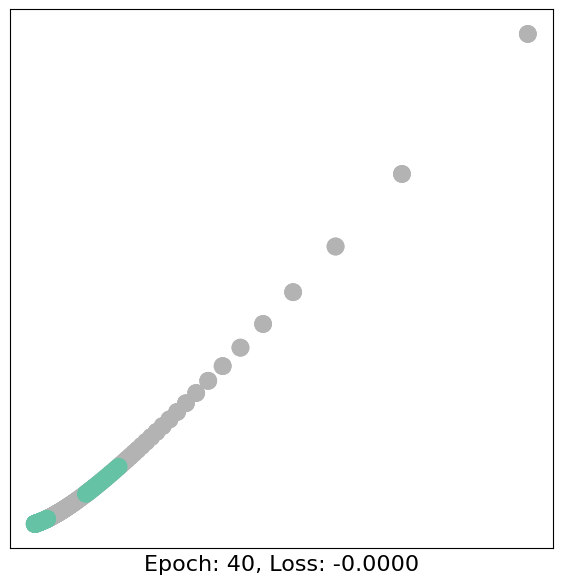

tensor(-0., grad_fn=<DivBackward1>)


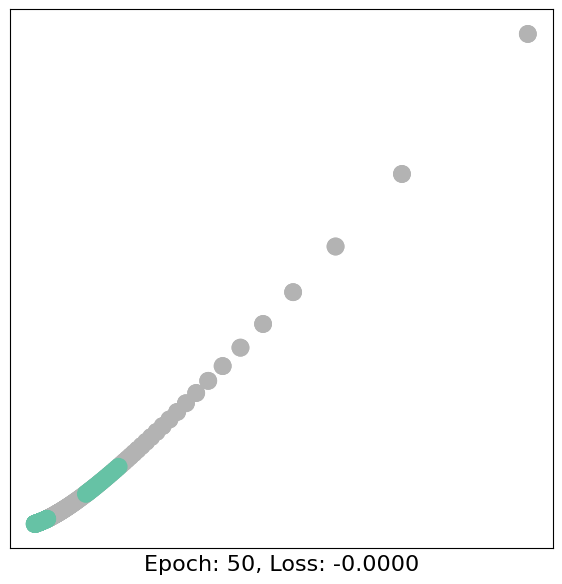

tensor(-0., grad_fn=<DivBackward1>)


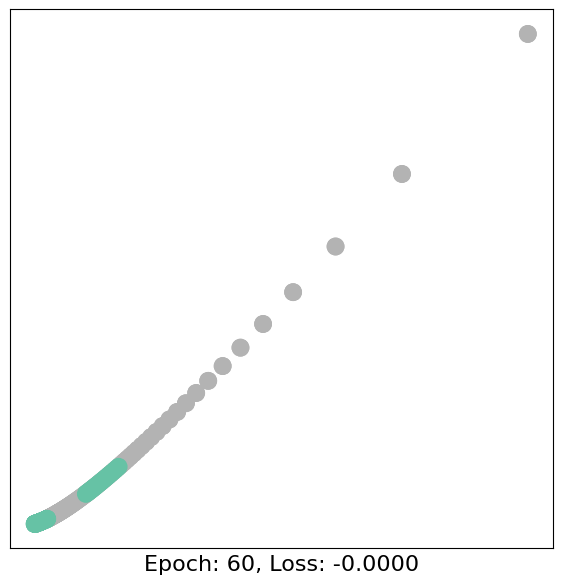

tensor(-0., grad_fn=<DivBackward1>)


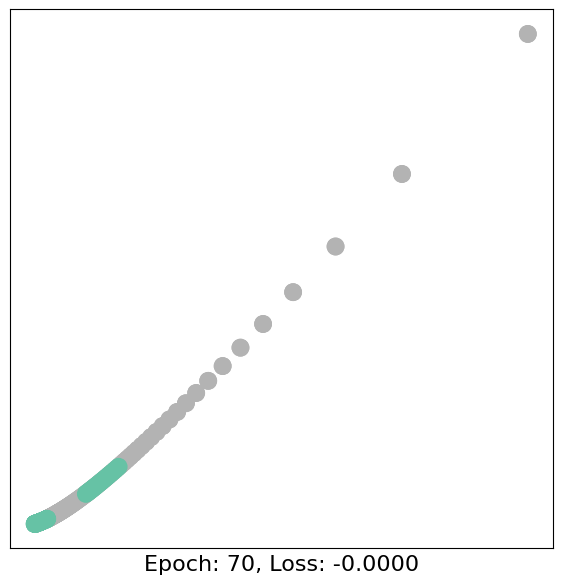

tensor(-0., grad_fn=<DivBackward1>)


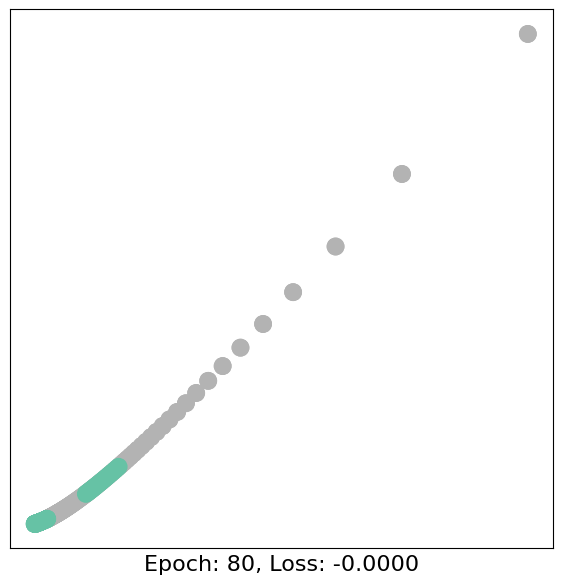

tensor(-0., grad_fn=<DivBackward1>)


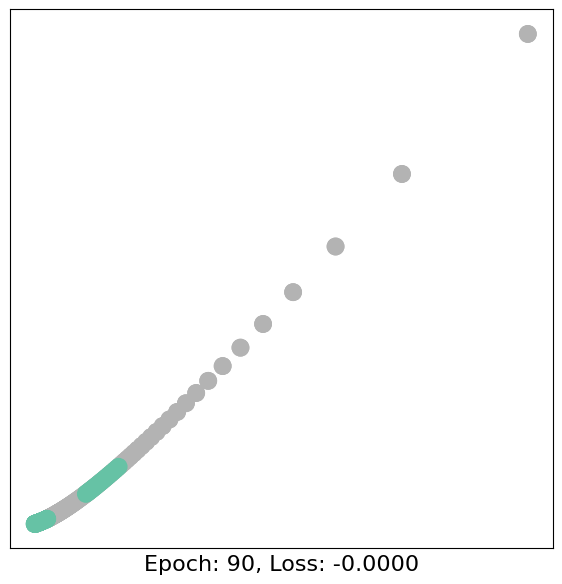

tensor(-0., grad_fn=<DivBackward1>)


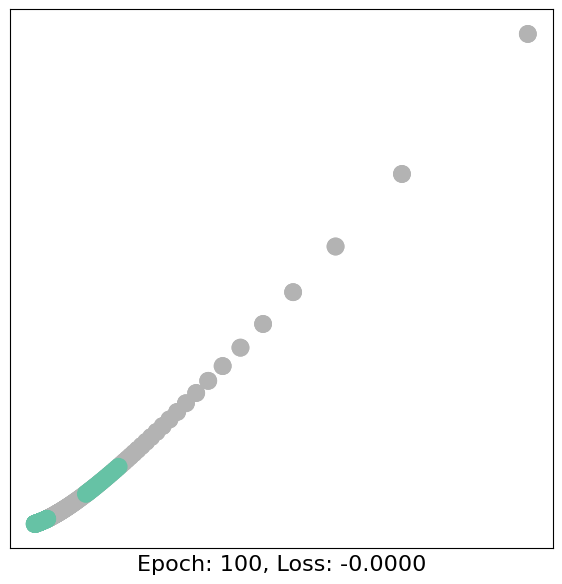

tensor(-0., grad_fn=<DivBackward1>)


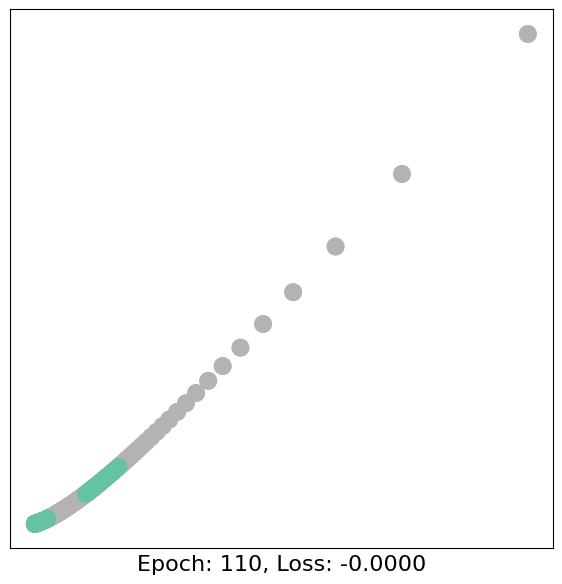

tensor(-0., grad_fn=<DivBackward1>)


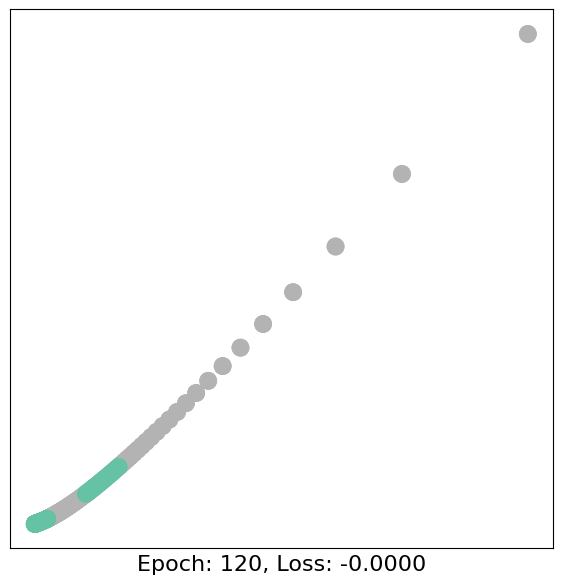

tensor(-0., grad_fn=<DivBackward1>)


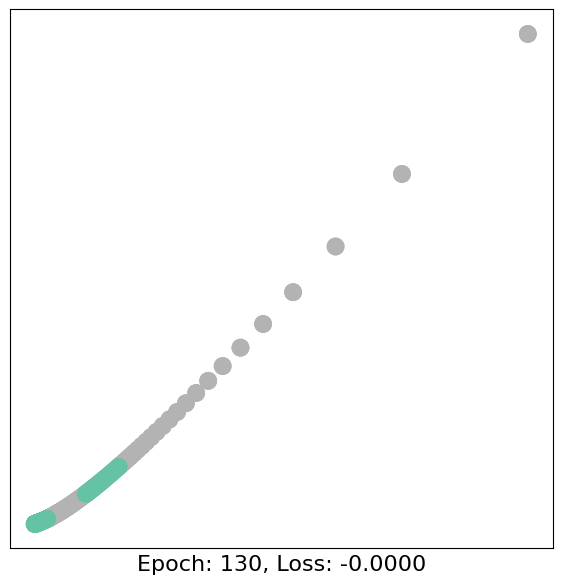

tensor(-0., grad_fn=<DivBackward1>)


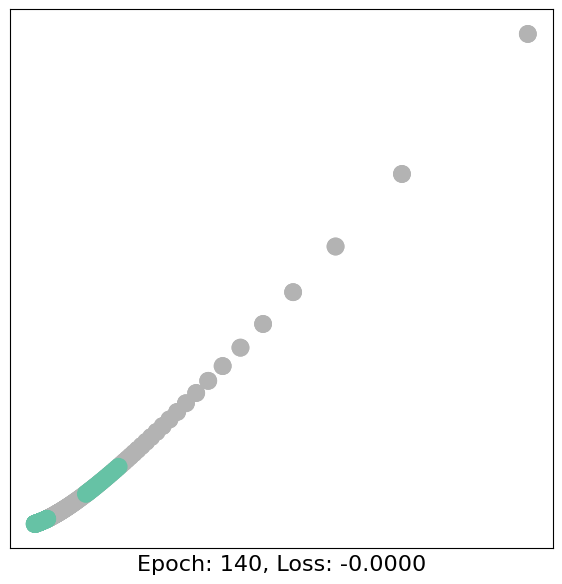

tensor(-0., grad_fn=<DivBackward1>)


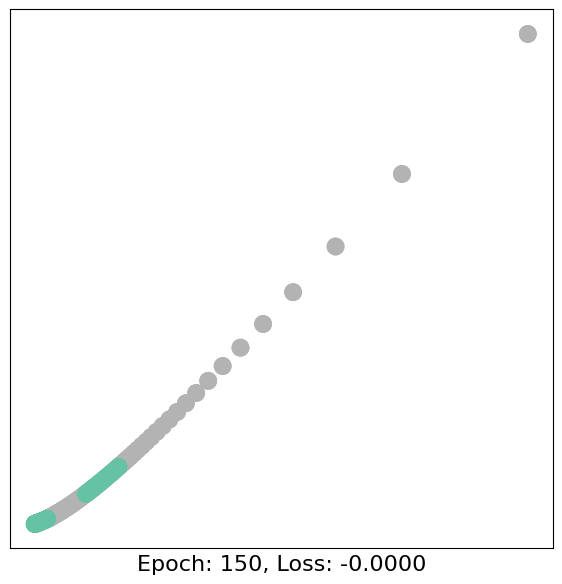

tensor(-0., grad_fn=<DivBackward1>)


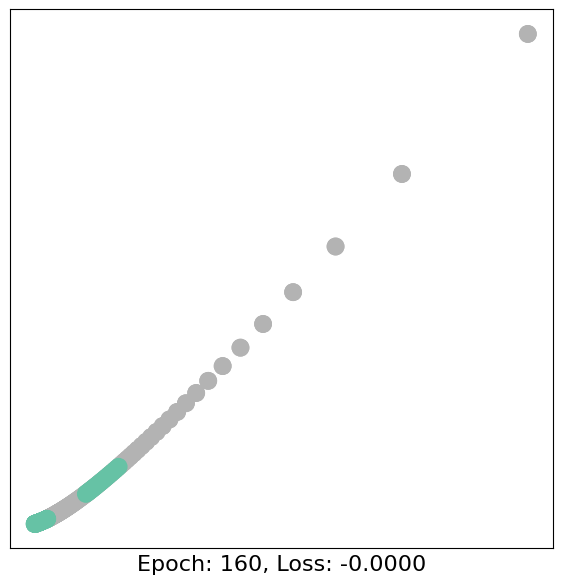

tensor(-0., grad_fn=<DivBackward1>)


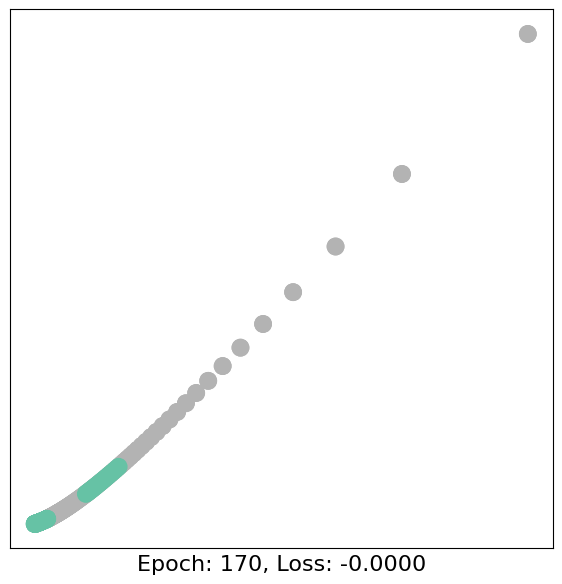

tensor(-0., grad_fn=<DivBackward1>)


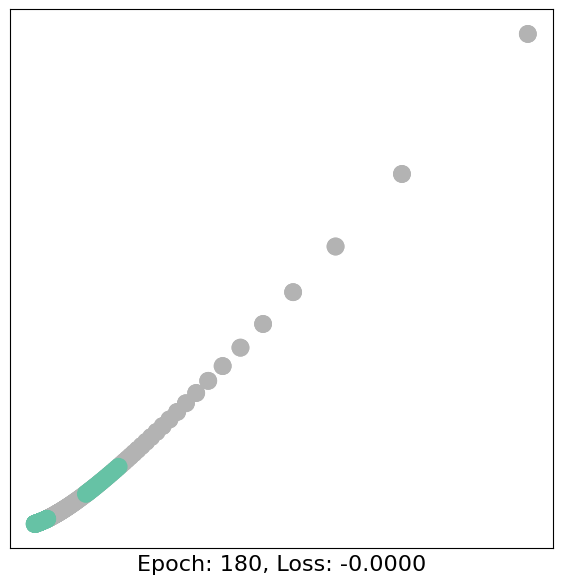

tensor(-0., grad_fn=<DivBackward1>)


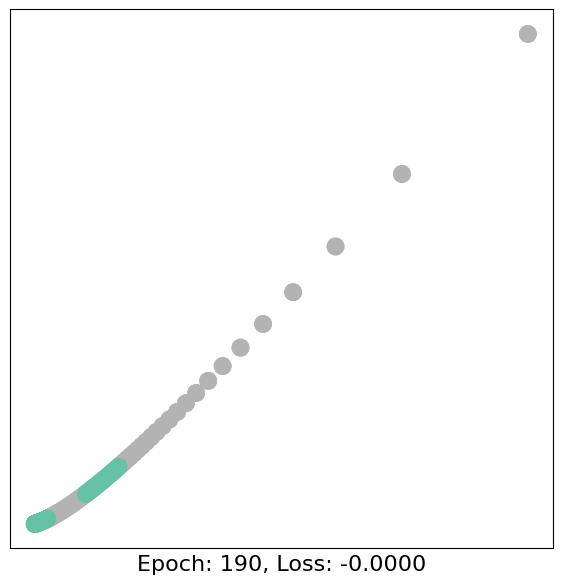

tensor(-0., grad_fn=<DivBackward1>)


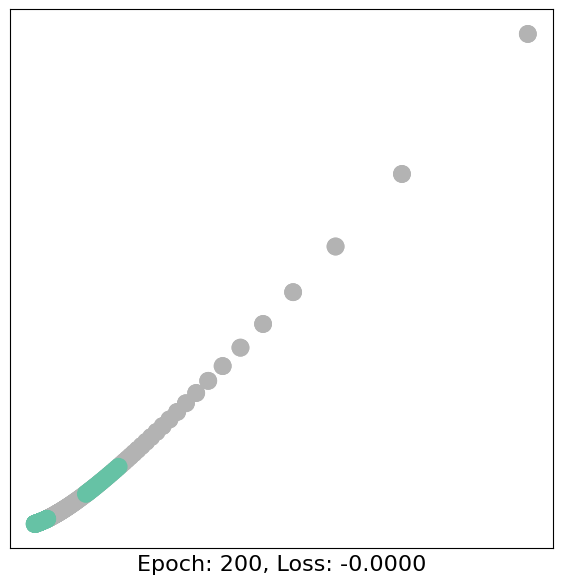

tensor(-0., grad_fn=<DivBackward1>)


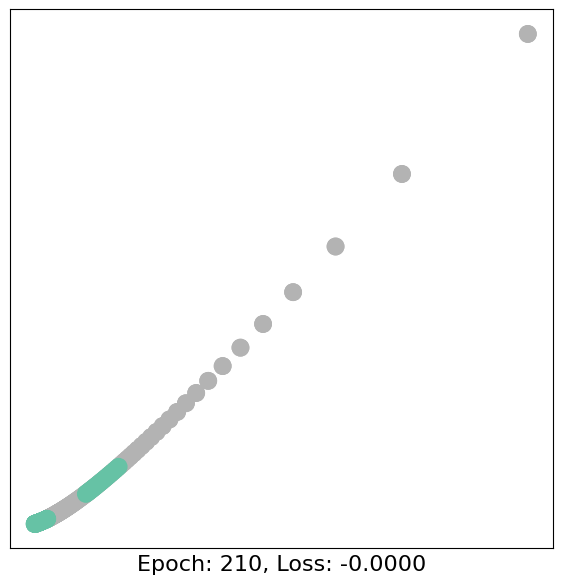

tensor(-0., grad_fn=<DivBackward1>)


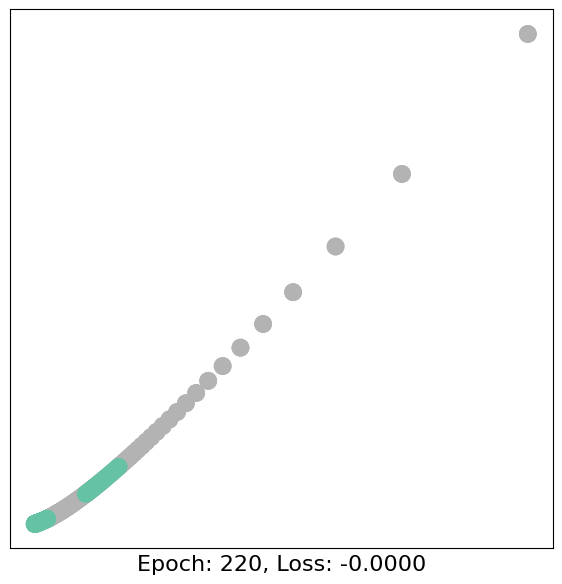

tensor(-0., grad_fn=<DivBackward1>)


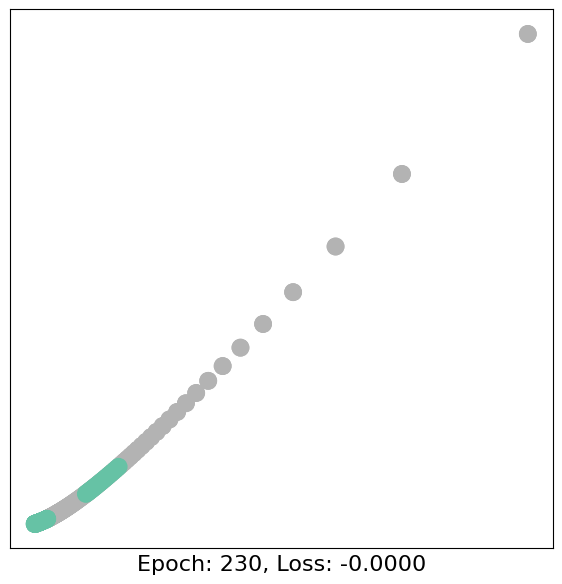

tensor(-0., grad_fn=<DivBackward1>)


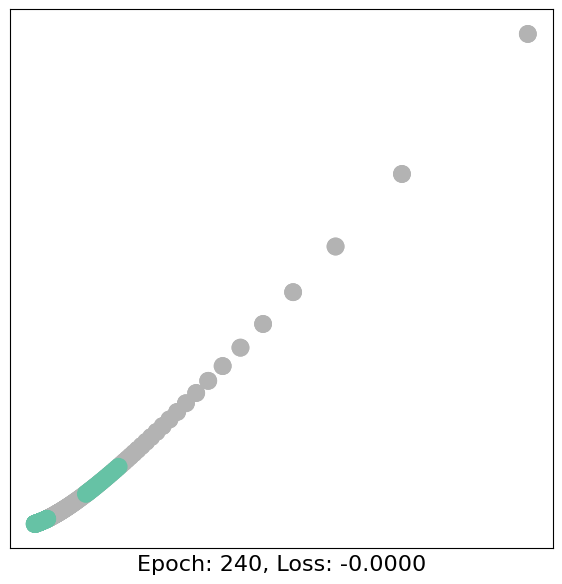

tensor(-0., grad_fn=<DivBackward1>)


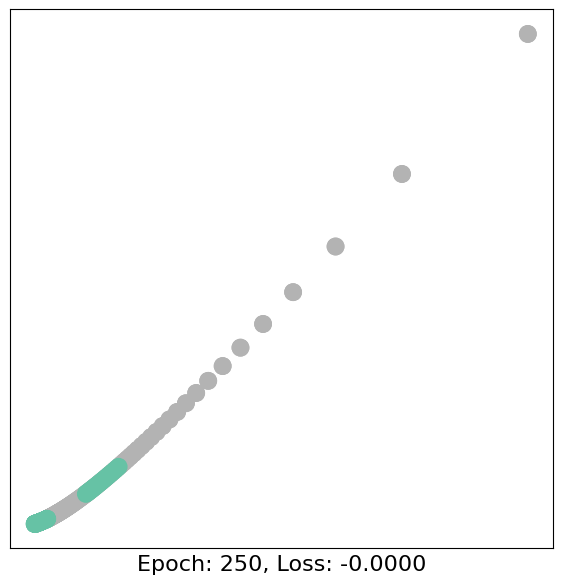

tensor(-0., grad_fn=<DivBackward1>)


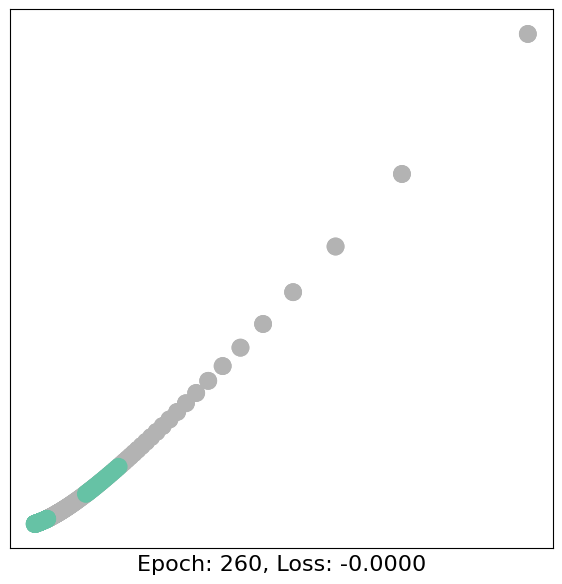

tensor(-0., grad_fn=<DivBackward1>)


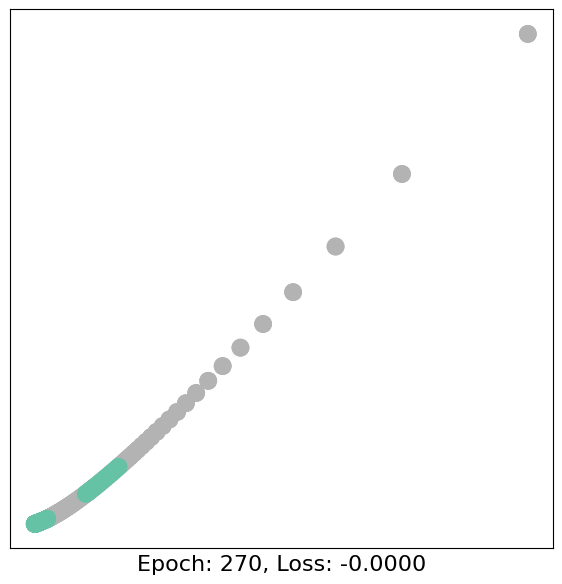

tensor(-0., grad_fn=<DivBackward1>)


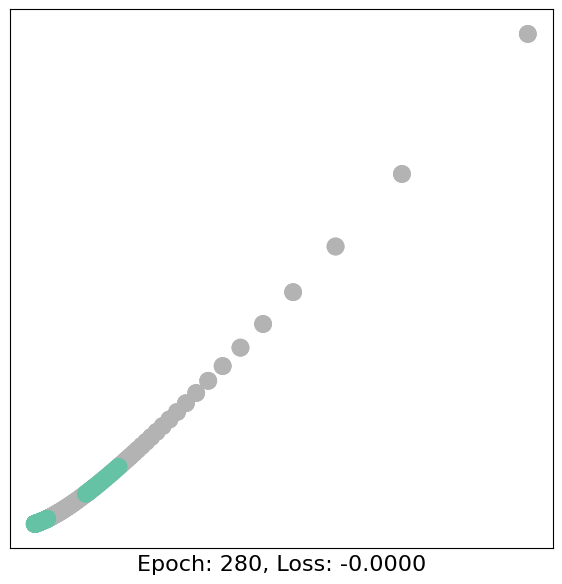

tensor(-0., grad_fn=<DivBackward1>)


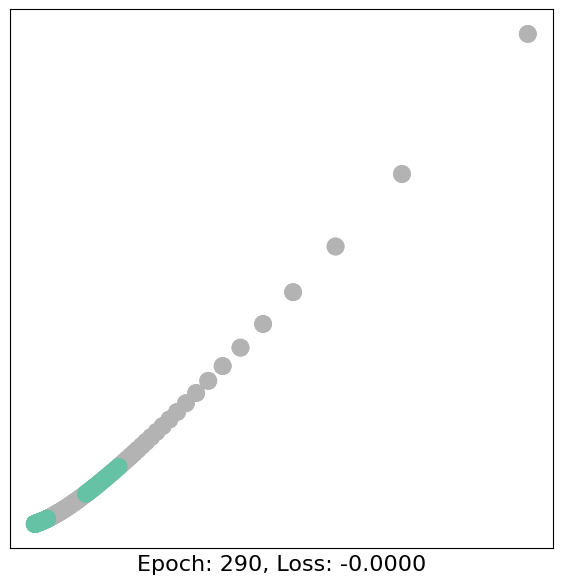

tensor(-0., grad_fn=<DivBackward1>)


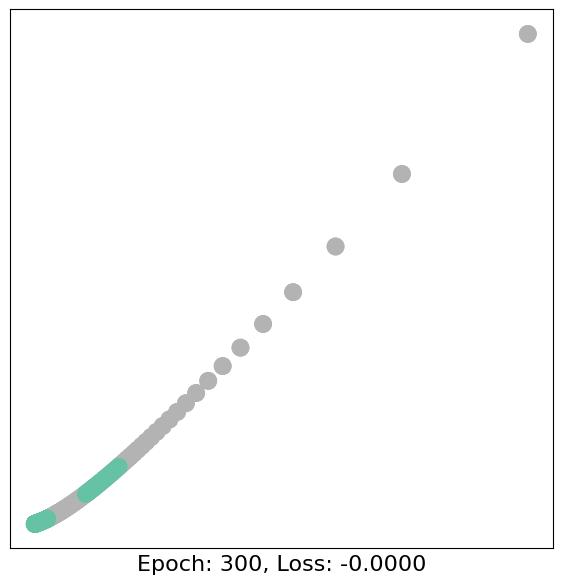

tensor(-0., grad_fn=<DivBackward1>)


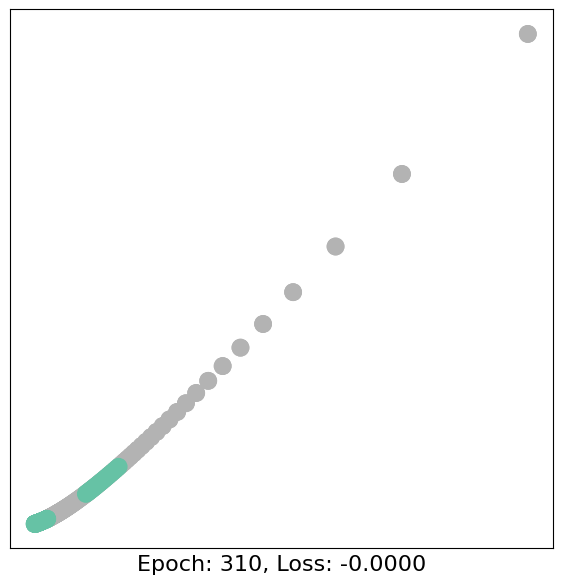

tensor(-0., grad_fn=<DivBackward1>)


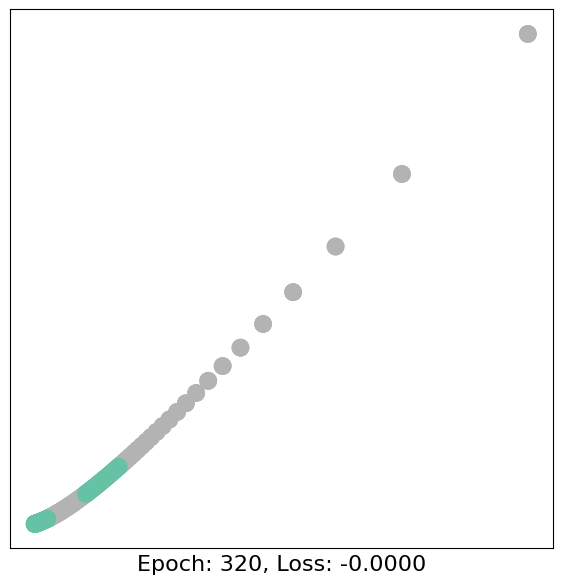

tensor(-0., grad_fn=<DivBackward1>)


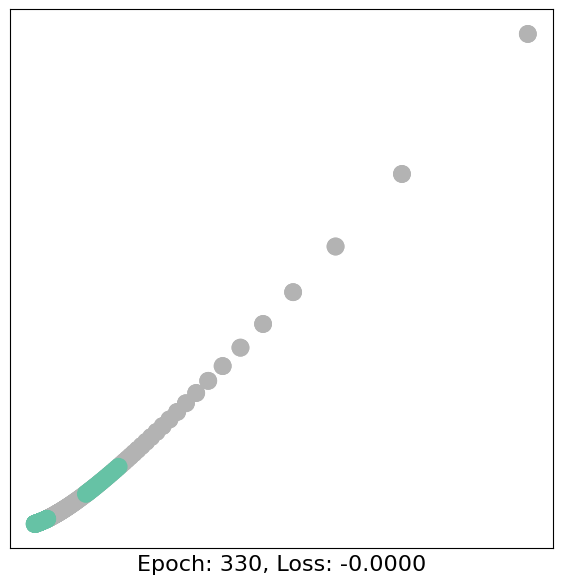

tensor(-0., grad_fn=<DivBackward1>)


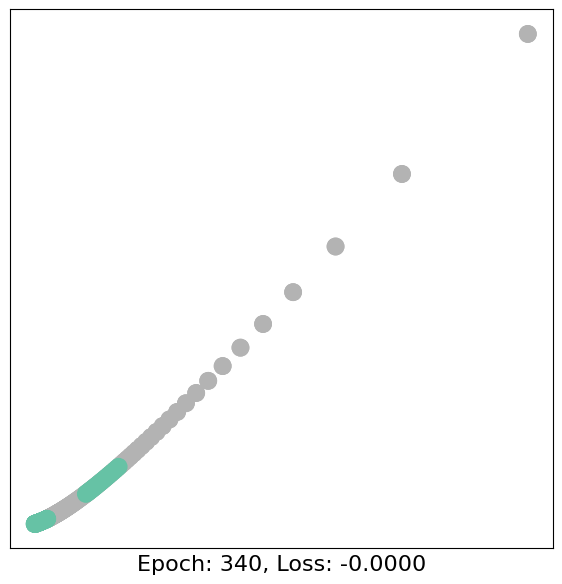

tensor(-0., grad_fn=<DivBackward1>)


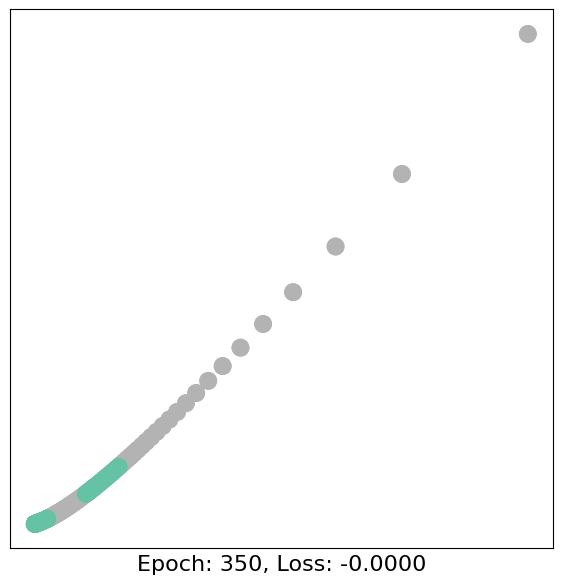

tensor(-0., grad_fn=<DivBackward1>)


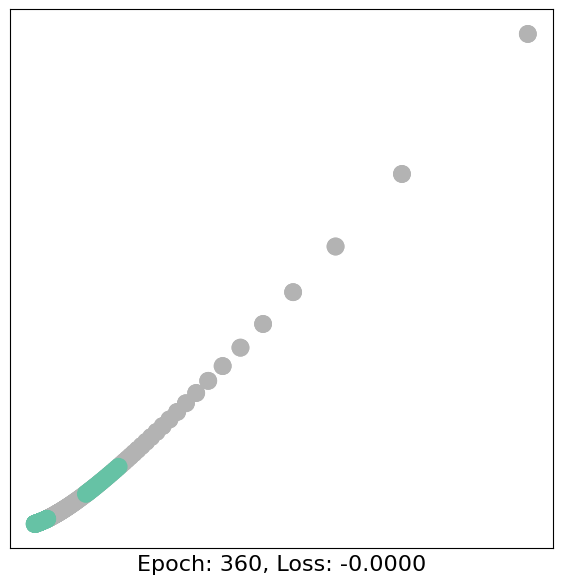

tensor(-0., grad_fn=<DivBackward1>)


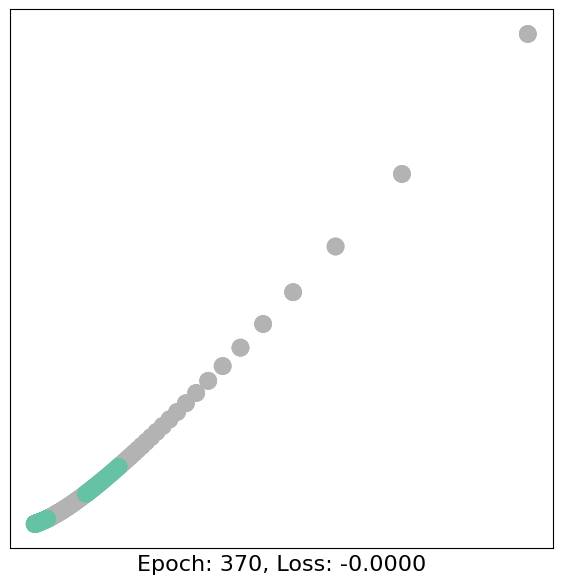

tensor(-0., grad_fn=<DivBackward1>)


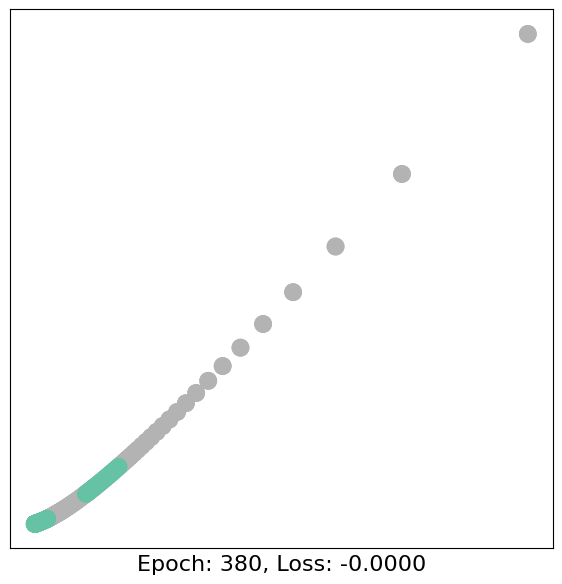

tensor(-0., grad_fn=<DivBackward1>)


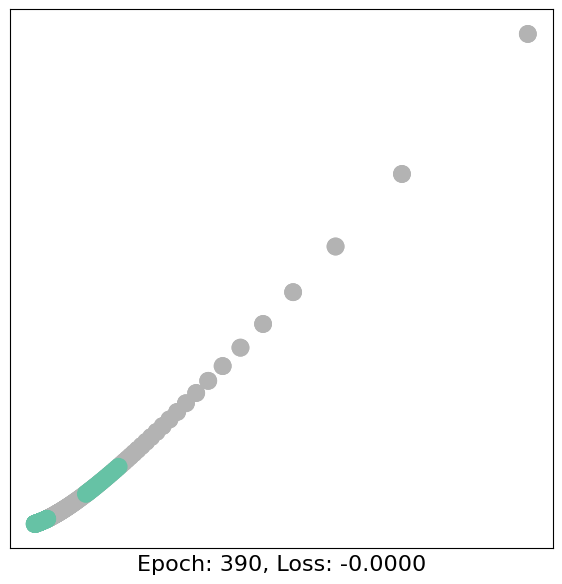

tensor(-0., grad_fn=<DivBackward1>)


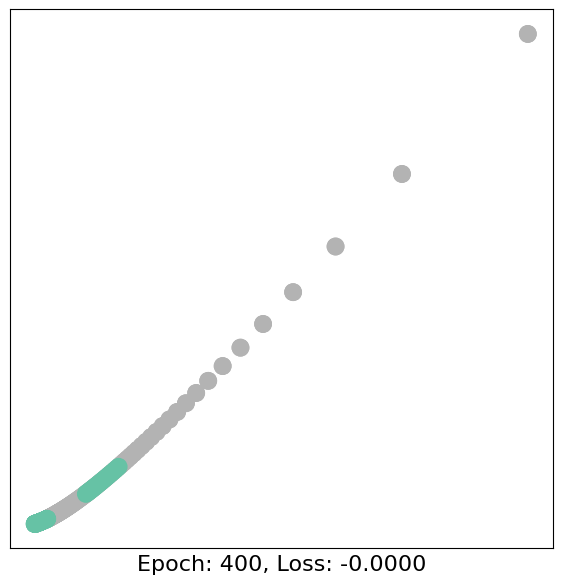

tensor(-0., grad_fn=<DivBackward1>)


In [61]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()# Define loss criterion.
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h


for epoch in range(401):    
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        print(loss)
        time.sleep(0.3)

In [65]:
# model.eval()
# pred = model(data).argmax(dim=1)
# correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
# acc = int(correct) / int(data.test_mask.sum())
# print(f'Accuracy: {acc:.4f}')
# model.eval()
# with torch.no_grad():
#     pred = model(data.x, data.edge_index).argmax(dim=1)
# correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
# acc = int(correct) / int(data.test_mask.sum())
# print(f'Accuracy: {acc:.4f}')
model.eval()
with torch.no_grad():
    out, _ = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 54.0000
